In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Module installation 
!pip install python-docx

In [ ]:


# CALLING PYTHON PACKAGES
import copy
import math
from termcolor import colored
import prompt_toolkit
from docx import Document
import matplotlib.pyplot as plt

import numpy as np
np.set_printoptions(suppress=True)
#np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})
import os

# Input

### Enter name of folder containing input files

In [ ]:
folder_name = "example" #@param {type:"string"}
frame_name = "example" #@param {type:"string"}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Nodes and Members in Plane Frame

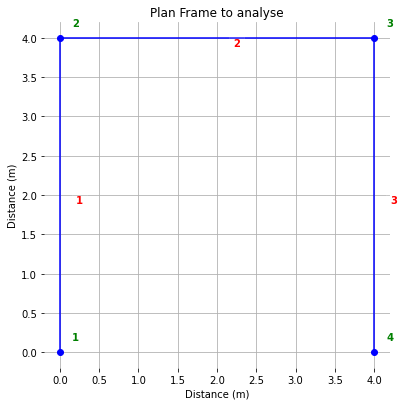

In [ ]:
# function to label member number
def text(x, y, txt):
    t = axes.text(x, y, txt, backgroundcolor="white",
                  ha='center', va='top', weight='bold', color='red', alpha=1)
    t.set_bbox(dict(facecolor='white', alpha=0.1, edgecolor='white'))
 
 
# function to label node number
def text2(x, y, txt):
    t = axes.text(x, y, txt, backgroundcolor="white",
                  ha='center', va='top', weight='bold', color='green', alpha=1)
    t.set_bbox(dict(facecolor='white', alpha=0.1, edgecolor='white'))

# open nodes file and take x and y co-ordinates of the nodes
nodes = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/'
                    +folder_name+'/PFnode.txt', dtype=float)
 
# open member file and take node i and node j numbers
members = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/'
                    +folder_name+'/PFmember.txt', dtype=int)
num_member, nodePermember = members.shape # stores row column size
# open support file and take restrained degree of freedom
restrainedDOF = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/'
                      +folder_name+'/PFrestraineddof.txt', dtype=int)
 
# open load file and take loading data
forceVector = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/'
              +folder_name+'/PFload.txt', dtype=float)

# open member load file and take data
memberload = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/'
                      +folder_name+'/PFmemberload.txt', dtype=float) 

# open member udl laod file and take data 
udl = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/'
                  +folder_name+'/PFudl.txt', dtype=float)
# PLOT THE Frame
fig = plt.figure(figsize=(6,6), frameon=False)
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.box(False)


# fig.gca().set_aspect('equal', adjustable='box')
i = 0
 
# annotate node numbers
for j in range(len(nodes)):
    text2(nodes[j, 0] + 0.2, nodes[j, 1] + 0.25, j + 1)
    
# plot members
 
for mbr in members:
    node_i = mbr[0]  # Node number for node i of this member
    node_j = mbr[1]  # Node number for node j of this member
 
    ix = nodes[node_i - 1, 0]  # x-coord of node i of this member
    iy = nodes[node_i - 1, 1]  # y-coord of node i of this member
    jx = nodes[node_j - 1, 0]  # x-coord of node j of this member
    jy = nodes[node_j - 1, 1]  # y-coord of node j of this member
 
    # annotate member number
    i = i + 1
     
    text(((ix + jx) /2) + .25, ((iy + jy) /2), i) 
    axes.plot([ix, jx], [iy, jy], 'b')  # Member
 
# Plot nodes
for node in nodes:
    axes.plot([node[0]], [node[1]], 'bo')
 
axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Plan Frame to analyse')
axes.grid()
plt.savefig("Plane Frame "+frame_name+".png")
plt.show()
 

### Assigning property and sectional area to members

In [ ]:

# Read material file
materials = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/'
            +folder_name+'/materialProperties.txt', dtype='float' )

for n in range(int(materials.size)):
  member_En = []
  if (materials.size >> 1):
    En = materials[n]
    print('E{} = '.format(n),En)
    member_En = input('Assign to memebrs (eneter member number with an space) :').split()
    print(colored('Section property Assigned','green',attrs=['bold']))
  else :
    E = float(materials)
    print('E = {} kN/sq.m'.format(E))
    member_En = members
    print(colored('Section property Assigned','green',attrs=['bold']))


# Read section file
sections = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/'+folder_name+'/sections.txt', dtype='float')

for n in range(int(sections.size/2)):
  
  member_An = []
  if (sections.size >> 2):
    An = round(sections[n,0],4)
    In = round(sections[n,1],7)
    print('A{} = '.format(n),An)
    print('I{} = '.format(n),In)
    member_An = input(colored('Assign to memebrs (eneter member number with an space) :','green',attrs=['bold'] )).split()
    print(colored('Section area and MOI Assigned','green',attrs=['bold']))
  else :
    A = round(sections[0],4)
    I = round(sections[1],7)
    print('A = {} sq.m'.format(A))
    print('I = {} qr.m'.format(I))
    member_An = members
    print(colored('Section area and MOI Assigned','green',attrs=['bold']))
  


E = 200000000.0 kN/sq.m
Section property Assigned
A = 0.01 sq.m
I = 1.33e-05 qr.m
Section area and MOI Assigned


# Functions

## Member length 

In [ ]:
# Function for member length
# Returns member length
def length(x1, x2, y1, y2):
  l = math.sqrt((x2-x1)**2+(y2-y1)**2)
  return l

## Element Stiffness Matrix

In [ ]:
# Function for element stiffness
# Member with no hinges
# Returns local stiffness matrix (6 x 6) 
def  elementStiffnesstype1 (E, A, I, L):
  K_local = np.array([[E*A/L,        0,             0,          -E*A/L,         0,                 0     ],
                     [  0,     12*E*I/(L**3),   6*E*I/(L**2),     0,       -12*E*I/(L**3),  6*E*I/(L**2)],
                     [  0,     6*E*I/(L**2),    4*E*I/L,          0,        -6*E*I/(L**2),    2*E*I/L   ],
                     [-E*A/L,       0,             0,           E*A/L,         0,                 0     ],
                     [  0,    -12*E*I/(L**3),  -6*E*I/(L**2),     0,       12*E*I/(L**3),  -6*E*I/(L**2) ],
                     [  0,     6*E*I/(L**2),    2*E*I/L,          0,       -6*E*I/(L**2),    4*E*I/L ]])
  return K_local


## Transformation Matrix

In [ ]:
# Function for transformation matrix
# Returns transformation matrix (6 X 6)
def elementTransformation (x1, x2, y1, y2):
  L = length(x1, x2, y1, y2)
  dx = x2 - x1
  dy = y2 - y1
  cosfi = dx/L
  sinfi = dy/L
  
  T = np.array([[ cosfi, sinfi, 0,   0,     0,   0 ],
               [-sinfi, cosfi, 0,   0,     0,   0 ],
               [  0,      0,   1,   0,     0,   0 ],
               [  0,      0,   0, cosfi, sinfi, 0 ],
               [  0,      0,   0,-sinfi, cosfi, 0 ],
               [  0,      0,   0,   0,     0,   1 ]])
  return [T, cosfi, sinfi]  

# Calculation

In [ ]:
# Main Calculation starts here

DoFs = len(nodes)*3                                # Total degree of freedom for whole frame
K_globalstructure = np.zeros([DoFs,DoFs])        # Initialize global matrix structure (DoFs X DoFs)


# Calculating Global Stiffness Matrix Structure
for n in range(len(members)):
    
    node_i = members[n][0]  # Node number for node i of this member
    node_j = members[n][1]  # Node number for node j of this member

    xi = nodes[node_i - 1][0]  # x-coord for node i
    yi = nodes[node_i - 1][1]  # y-coord for node i
    xj = nodes[node_j - 1][0]  # x-coord for node j
    yj = nodes[node_j - 1][1]  # y-coord for node j
    
    L = length(xi, xj, yi, yj)
    [T, cosfi, sinfi] = elementTransformation(xi, xj, yi, yj)
    K_local = elementStiffnesstype1 (E, A, I, L)
    K_global = np.matmul(np.matmul(np.transpose(T),K_local),T)
    
    Dofi = (3*node_i)-2 # x-Degree OF Freedom for start node (i)
    Dofj = (3*node_j)-2 # x-Degree OF Freedom for end node (j)

    # Add the element's global stiffness matrix [6x6] to the appropriate 
    # position in the structure's global stiffness matrix [NumNodes*3 x NumNodes*3]
    print(colored('Global Member Stiffness Matrix','green',attrs=['bold']))
    print(colored('Member No. = {}'.format(n+1),'red'),'cos Φ = {}'.format(cosfi), 'sin Φ = {}'.format(sinfi))
    print(np.around(K_global, decimals=2),'\n')
    K_globalstructure[Dofi-1:Dofi+2,Dofi-1:Dofi+2]= K_globalstructure[Dofi-1:Dofi+2,Dofi-1:Dofi+2]+ K_global[0:3,0:3]
    K_globalstructure[Dofj-1:Dofj+2,Dofj-1:Dofj+2]= K_globalstructure[Dofj-1:Dofj+2,Dofj-1:Dofj+2]+ K_global[3:6,3:6]
    K_globalstructure[Dofi-1:Dofi+2,Dofj-1:Dofj+2]= K_globalstructure[Dofi-1:Dofi+2,Dofj-1:Dofj+2]+ K_global[0:3,3:6]
    K_globalstructure[Dofj-1:Dofj+2,Dofi-1:Dofi+2]= K_globalstructure[Dofj-1:Dofj+2,Dofi-1:Dofi+2]+ K_global[3:6,0:3]
    

print(colored('Global Structure Matrix','blue',attrs=['bold']))
print(np.around(K_globalstructure, decimals=2))  

restrainedIndex = [x - 1 for x in restrainedDOF]  # Index for each restrained DoF (list comprehension)

# Reduce to structure stiffness matrix by deleting rows and columns for restrained DoF
Ks = np.delete(K_globalstructure, restrainedIndex, 0)  # Delete rows
Ks = np.delete(Ks, restrainedIndex, 1)  # Delete columns
Ks = np.matrix(Ks)  # Convert Ks from numpy.ndarray to numpy.matrix to use build in inverter function

forceVectorRed = copy.copy(forceVector)  # Make a copy of forceVector so the copy can be edited, leaving the original unchanged
forceVectorRed = np.delete(forceVectorRed, restrainedIndex, 0)  # Delete rows corresponding to restrained DoF

cosfi = 0; sinfi = 1;
T = np.array([[ cosfi, sinfi, 0,   0,     0,   0 ],
               [-sinfi, cosfi, 0,   0,     0,   0 ],
               [  0,      0,   1,   0,     0,   0 ],
               [  0,      0,   0, cosfi, sinfi, 0 ],
               [  0,      0,   0,-sinfi, cosfi, 0 ],
               [  0,      0,   0,   0,     0,   1 ]])
u = Ks.I.dot(forceVectorRed)
U = u.T


# Construct the global displacement vector
UG = np.zeros(DoFs)  # Initialise an array to hold the global displacement vector
c = 0  # Initialise a counter to track how many restraints have been imposed

for i in np.arange(DoFs):
    if i in restrainedIndex:
        # Impose zero displacement
        UG[i] = 0
    else:
        # Assign actual displacement
        UG[i] = U[c]
        c = c + 1
UG = np.array([UG]).T

FG = np.matmul(K_globalstructure, UG)
print(colored('Reactions at restrained nodes\n', 'red',attrs=['bold']),np.around(FG, decimals=4))
mbrForces = np.array([])  # Initialise an array to hold member forces
memberForceMatrix = np.array([]) # initialized matrix to hold member forces
for n, mbr in enumerate(members):
    
    node_i = mbr[0]  # Node number for node i of this member
    node_j = mbr[1]  # Node number for node j of this member

    xi = nodes[node_i - 1][0]  # x-coord for node i
    yi = nodes[node_i - 1][1]  # y-coord for node i
    xj = nodes[node_j - 1][0]  # x-coord for node j
    yj = nodes[node_j - 1][1]  # y-coord for node j

    # Primary stiffness matrix indices associated with each node
    ia = 3 * node_i - 3
    ib = 3 * node_i - 2
    ic = 3 * node_i - 1
    ja = 3 * node_j - 3
    jb = 3 * node_j - 2
    jc = 3 * node_j - 1

    # Transformation matrix
    [T, cosfi, sinfi] = elementTransformation(xi, xj, yi, yj)
      
    L = length(xi, xj, yi, yj)  
    K_local = elementStiffnesstype1 (E, A, I, L)
     
    
    # Global and local displacement matrix
    disp_global = np.array([[UG[ia], UG[ib],UG[ic], UG[ja], UG[jb],UG[jc]]]).T  # Global displacements
    disp_local = np.matmul(T, disp_global)[0]  # Local displacements
        
    # Member forces
    memberForces = np.transpose(np.matmul(K_local,disp_local)) + memberload[n]  # Calculating memeber force
    memberForceMatrix = np.append(memberForceMatrix, memberForces)  # Storing member forces 
    # print result
    print(colored('member no. {}'.format(n+1), 'red', attrs=['bold']))
    print('global displacement matrix\n', np.around(disp_global, decimals=6))
    print('local displacement matrix\n', np.around(disp_local, decimals=6))
    print(colored('member force {}\n'.format(n+1), 'red', attrs=['bold']), np.around(memberForces, decimals=3))  
modifiedMemeberForceMatrix = memberForceMatrix.reshape(num_member,6)



Global Member Stiffness Matrix
Member No. = 1 cos Φ = 0.0 sin Φ = 1.0
[[    498.75       0.      -997.5     -498.75       0.      -997.5 ]
 [      0.    500000.         0.         0.   -500000.         0.  ]
 [   -997.5        0.      2660.       997.5        0.      1330.  ]
 [   -498.75       0.       997.5      498.75       0.       997.5 ]
 [      0.   -500000.         0.         0.    500000.         0.  ]
 [   -997.5        0.      1330.       997.5        0.      2660.  ]] 

Global Member Stiffness Matrix
Member No. = 2 cos Φ = 1.0 sin Φ = 0.0
[[ 500000.         0.         0.   -500000.         0.         0.  ]
 [      0.       498.75     997.5        0.      -498.75     997.5 ]
 [      0.       997.5     2660.         0.      -997.5     1330.  ]
 [-500000.         0.         0.    500000.         0.         0.  ]
 [      0.      -498.75    -997.5        0.       498.75    -997.5 ]
 [      0.       997.5     1330.         0.      -997.5     2660.  ]] 

Global Member Stiffness Ma

### Print results

# Plot Shear Force Daigram

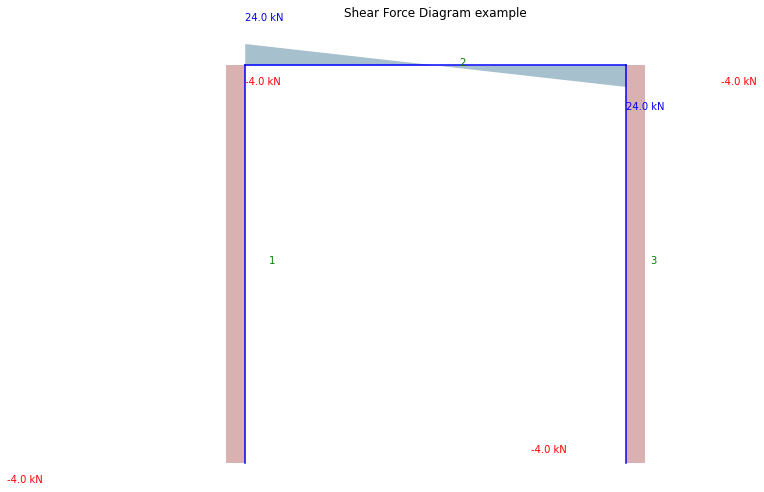

In [ ]:
# PLOT SHARE FORCE DAIGRAM
if (num_member > 15):
  xfig = 12
  yfig = 12
else:
  xfig = 8
  yfig = 8
fig = plt.figure(figsize=(xfig,yfig))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
xFac = 0.05
yFac = 0.009
i = 0
# Plot members
for n, mbr in enumerate(members):
    node_i = mbr[0]  # Node number for node i of this member
    node_j = mbr[1]  # Node number for node j of this member

    ix = nodes[node_i - 1, 0]  # x-coord of node i of this member
    iy = nodes[node_i - 1, 1]  # y-coord of node i of this member
    jx = nodes[node_j - 1, 0]  # x-coord of node j of this member
    jy = nodes[node_j - 1, 1]  # y-coord of node j of this member

    
    # Index of DoF for this member
    ia = 2 * node_i - 2  # horizontal DoF at node i of this member
    ib = 2 * node_i - 1  # vertical DoF at node i of this member
    ja = 2 * node_j - 2  # horizontal DoF at node j of this member
    jb = 2 * node_j - 1  # vertical DoF at node j of this member

    # annotate member number
    i = i + 1
    axes.text(((ix + jx) /2) + .25, ((iy + jy) /2), i, color='green') 
    
    
    axes.plot([ix, jx], [iy, jy], 'b')  # Member

    # Plot Shear Force Diagram
    [T, cosfi, sinfi] = elementTransformation(ix, jx, iy, jy)
    
    if (cosfi == 0):
      # Shear force calculation  
      # Fill Plot Vertical
      x = [ix + modifiedMemeberForceMatrix[n,1]* xFac, jx - modifiedMemeberForceMatrix[n,4] * xFac]
      y = [iy, jy ]
      axes.fill_betweenx(y,ix,x, facecolor=(.51, 0, 0,0.3))
      if (iy < jy):
        # Annotate Shear Force value
        txt1 = str(np.around(modifiedMemeberForceMatrix[n,1],decimals=1))
        axes.text(ix-2.5, iy-.2,txt1+' kN', color='red', fontsize=10)  

        txt2 = str(-np.around(modifiedMemeberForceMatrix[n,4],decimals=1))
        axes.text(jx, jy-.2,txt2+' kN', color='red', fontsize=10) 
      else:
        # Annotate Shear Force value
        txt1 = str(-np.around(modifiedMemeberForceMatrix[n,1],decimals=1))
        axes.text(ix+1, iy-.2,txt1+' kN', color='red', fontsize=10)  

        txt2 = str(np.around(modifiedMemeberForceMatrix[n,4],decimals=1))
        axes.text(jx-1, jy+.1,txt2+' kN', color='red', fontsize=10)

    else:

      # Fill Plot Horizontal
      x = [ix, jx]
      y = [iy + modifiedMemeberForceMatrix[n,1]* yFac, jy - modifiedMemeberForceMatrix[n,4] * yFac]
      axes.fill_between(x,iy,y,facecolor=(.31, .51, .61,0.5))
   
      # Annotate Shear Force value
      txt1 = str(np.around(modifiedMemeberForceMatrix[n,1],decimals=1))
      axes.text(ix, iy+.45,txt1+' kN', color='blue', fontsize=10)  

      txt2 = str(np.around(modifiedMemeberForceMatrix[n,4],decimals=1))
      axes.text(jx, jy-.45,txt2+' kN', color='blue', fontsize=10) 


    
axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Shear Force Diagram '+ frame_name)
axes.grid(False)
axes.axis('off')
plt.savefig('Shear Force Diagram '+frame_name+'.png')
plt.show()

# Plot Bending Moment Diagram

member no.1 Mid moment=-8.0
member no.3 Mid moment=-8.0


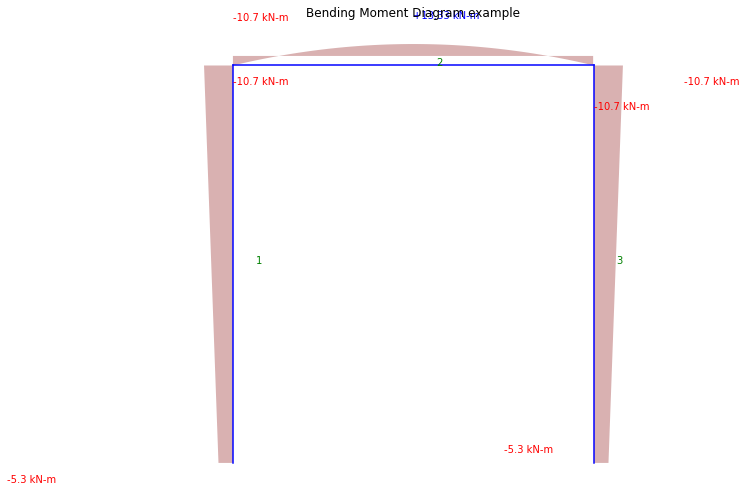

In [ ]:
# Initializing plot size depending on member numbers
if (num_member > 15): # Plot size 
  xfig = 12
  yfig = 12
else:
  xfig = 8
  yfig = 8
fig = plt.figure(figsize=(xfig,yfig))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
xFac = 0.03
yFac = 0.009
i = 0
midMomentMat = []
# Plot members
for n, mbr in enumerate(members):
    node_i = mbr[0]  # Node number for node i of this member
    node_j = mbr[1]  # Node number for node j of this member

    ix = nodes[node_i - 1, 0]  # x-coord of node i of this member
    iy = nodes[node_i - 1, 1]  # y-coord of node i of this member
    jx = nodes[node_j - 1, 0]  # x-coord of node j of this member
    jy = nodes[node_j - 1, 1]  # y-coord of node j of this member

    
    # Index of DoF for this member
    ia = 2 * node_i - 2  # horizontal DoF at node i of this member
    ib = 2 * node_i - 1  # vertical DoF at node i of this member
    ja = 2 * node_j - 2  # horizontal DoF at node j of this member
    jb = 2 * node_j - 1  # vertical DoF at node j of this member
    
    # annotate member number
    i = i + 1
    axes.text(((ix + jx) /2) + .25, ((iy + jy) /2), i, color='green') 
    
    
    axes.plot([ix, jx], [iy, jy], 'b')  # Member

    # Plot Bending moment Diagram
    [T, cosfi, sinfi] = elementTransformation(ix, jx, iy, jy)
    l = length(ix, jx, iy, jy)  
    M1 = max(abs(modifiedMemeberForceMatrix[n,2]), abs(modifiedMemeberForceMatrix[n,5]))
    M2 = min(abs(modifiedMemeberForceMatrix[n,2]), abs(modifiedMemeberForceMatrix[n,5]))
    
    if (cosfi == 0):

      # Fill Plot Vertical
      x = [ix + modifiedMemeberForceMatrix[n,2]* xFac, jx + modifiedMemeberForceMatrix[n,5] * xFac]
      y = [iy, jy]
      
      axes.fill_betweenx(y,ix,x, facecolor=(.51, 0, 0,0.3))
     
      mid_moment = np.around((udl[n]*l**2/8)-(M2 + 0.5*(M1-M2)),decimals=2)
      midMomentMat = np.append(midMomentMat, mid_moment)
      
      print('member no.{}'.format(n+1), 'Mid moment={}'.format(mid_moment))
      if (iy < jy):
        # Annotate -ve Bending Moment value
        txt1 = str(np.around(modifiedMemeberForceMatrix[n,2],decimals=1))
        axes.text(ix-2.5, iy-.2,txt1+' kN-m', color='red', fontsize=10)  

        txt2 = str(np.around(modifiedMemeberForceMatrix[n,5],decimals=1))
        axes.text(jx, jy-.2,txt2+' kN-m', color='red', fontsize=10) 
      else:
        # Annotate -ve Bending Moment value
        txt1 = str(-np.around(modifiedMemeberForceMatrix[n,2],decimals=1))
        axes.text(ix+1, iy-.2,txt1+' kN-m', color='red', fontsize=10)  

        txt2 = str(-np.around(modifiedMemeberForceMatrix[n,5],decimals=1))
        axes.text(jx-1, jy+.1,txt2+' kN-m', color='red', fontsize=10)
        
    else:

      # Fill Plot Horizontal support moment
      x = [ix, jx]
      y = [iy + modifiedMemeberForceMatrix[n,2]* yFac, jy - modifiedMemeberForceMatrix[n,5] * yFac]
      
      # Fill plot positive moment
      x1 = np.arange(0,jx-ix,0.01)  
      y1 = np.array(iy + (udl[n]*x1*0.5*(l-x1))*yFac)
      x2 = np.arange(ix,jx,0.01)
      size = x2.size
      y2 = np.linspace(iy + modifiedMemeberForceMatrix[n,2]* yFac,
                       jy - modifiedMemeberForceMatrix[n,5] * yFac,size)
      axes.fill_between(x2,y2,y1, facecolor=(.51, 0, 0,0.3))

      # Annotate -ve Bending Moment value
      txt1 = str(-np.around(modifiedMemeberForceMatrix[n,2],decimals=1))
      axes.text(ix, iy+.45,txt1+' kN-m', color='red', fontsize=10)  

      txt2 = str(np.around(modifiedMemeberForceMatrix[n,5],decimals=1))
      axes.text(jx, jy-.45,txt2+' kN-m', color='red', fontsize=10) 

      # Annotate +ve bending moment at mid span
      mid_moment = np.around((udl[n]*l**2/8)-(M2 + 0.5*(M1-M2)),decimals=2)
      txt3 = '+'+str(mid_moment)+ ' kN-m'
      axes.text((ix+jx)/2, iy+mid_moment*yFac+0.35,txt3, color='blue', fontsize=10)
      midMomentMat = np.append(midMomentMat, mid_moment)

      
    
axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Bending Moment Diagram '+frame_name)
axes.grid(False)
axes.axis('off')
plt.savefig("Bending Moment Diagram "+frame_name+".png")
plt.show()

# Output File 

In [ ]:
# WRITING OUT IN WORD FILE

document = Document()
document.add_heading('Plane '+frame_name+' analysis Report Using Python', 0)

document.add_picture("Plane Frame "+frame_name+".png")

document.add_heading('Reactions (+ve upward/right, -ve downwards/left)', level=1)
document.styles['Normal'].font.name = 'Times New Roman'
for i in np.arange(0, len(restrainedIndex)):
    index = restrainedIndex[i]
    if ((index+1)%3==0):
      unit = ' kN-m'
    else:
      unit = ' kN'
        
    document.add_paragraph('Reaction at DoF ' + str(index + 1) + ' : ' + str(round(FG[index].item(), 2)) + unit) 
                           

document.add_heading('Member Forces', level=1)
table = document.add_table(rows=num_member+1, cols=7)
heading = ['Member No.', 'Left Axial Force (kN)', 'Left Shear Force (kN)', 
           'Left Bending Moment (kN-m)', 'Right Axial Force (kN)', 
           'Right Shear Force (kN)', 'Right Bending Moment (kN-m)']
for i in range(7):
  table.cell(0,i).text=heading[i]

for n, mbr in enumerate(members):
    table.cell(n+1,0).text=str(n + 1)
    for i in range(6):
      table.cell(n+1,i+1).text=str(np.around(modifiedMemeberForceMatrix[n,i], decimals=2))

# Shear Force Table
document.add_heading('Shear Forces and Bending Moment', level=1)
table = document.add_table(rows=num_member+1, cols=6)
heading = ['Member No.', 'Left Shear Force (kN)', 'Right Shear Force (kN)','Left Support Moment (kN-m)', 'Mid-Span Moment (kN-m)', 'Right Support Moment (kN-m)']
for i in range(6):
  table.cell(0,i).text=heading[i]

for n, mbr in enumerate(members):
    [T, cosfi, sinfi] = elementTransformation(ix, jx, iy, jy)
    l = length(xi, xj, yi, yj)  
    table.cell(n+1,0).text=str(n + 1)
    table.cell(n+1,1).text=str(np.around(modifiedMemeberForceMatrix[n,1], decimals=2))
    if (cosfi == 0):
      table.cell(n+1,2).text=str(-np.around(modifiedMemeberForceMatrix[n,4], decimals=2))
    else:
       table.cell(n+1,2).text=str(-np.around(modifiedMemeberForceMatrix[n,4], decimals=2))
    table.cell(n+1,3).text=str(np.around(modifiedMemeberForceMatrix[n,2], decimals=2)) 
    table.cell(n+1,4).text=str(np.around(midMomentMat[n], decimals=2)) 
    table.cell(n+1,5).text=str(np.around(modifiedMemeberForceMatrix[n,5], decimals=2)) 

document.add_heading('Nodal Displacements (+ve upward, -ve downwards)', level=1)
for n, node in enumerate(nodes):
    ix = 2 * (n + 1) - 2  # horizontal DoF for this node
    iy = 2 * (n + 1) - 1  # vertical DoF for this node

    ux = round(UG[ix, 0], 5)  # Horizontal nodal displacement
    uy = round(UG[iy, 0], 5)  # Vertical nodal displacement
    document.add_paragraph('Node ' + str(n + 1) + ' : ' + 'Ux = ' + str(ux) + ' m,' + 'Uy = ' + str(uy) + ' m')

# document.add_picture('Shear Force Diagram.png')
document.add_heading('Prepared by D Mandal', 2)
document.save('Plane Frame Result '+frame_name+'.docx')